# Image segmentation
## 1.import module
### model is based on [TensorFlow](https://tensorflow.org)

In [1]:
import tensorflow as tf
from cUnet import downsample, upsample

from MeanIoU import MIoU

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

import datetime

from IPython.display import clear_output

from LoadData import Lab2DataLoader

## 2.load data
from class [Lab2DataLoader](LoadData.py) load from [lab2_train_data.h5](lab2_train_data.h5) & [lab2_test_data.h5](lab2_test_data.h5)
> **train_img:** dictionary {\"image\":test image,\"mask\":test mask}
> **test_img:** dictionary {\"image\":test image,\"mask\":test mask}
> **color_codes** segmentation colors

In [2]:
train_img, test_img, color_codes = Lab2DataLoader().loadData()
INPUT_SHAPE = train_img['image'].shape[1:]
TRAIN_LENGTH = train_img['image'].shape[0]
TEST_LENGTH = test_img['image'].shape[0]
CLASSES = color_codes.shape[0]

cmap = colors.ListedColormap(color_codes / 255.0, "color_codes")
norm = colors.BoundaryNorm(np.arange(0, CLASSES), cmap.N)

print(f'dataset shape: train {train_img["image"].shape} test {test_img["image"].shape}')

dataset shape: train (2975, 128, 256, 3) test (500, 128, 256, 3)


### 2.1 normalize image

In [125]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 2.2 Augment: Random Horizontal Flip,Random Contrast and RandomZoom

In [126]:
ratio = 1
trans_factor = (-.05, .05)
zoom_factor = (-.05, 0)


class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomContrast((.25, .25)),
            # tf.keras.layers.RandomTranslation(trans_factor,trans_factor,fill_mode="constant", seed=seed),
            tf.keras.layers.RandomZoom(zoom_factor, fill_mode="constant", seed=seed),
            # tf.keras.layers.RandomCrop(int(np.round(128 * ratio)), int(np.round(256 * ratio)), seed=seed),
            # tf.keras.layers.Resizing(128, 256, crop_to_aspect_ratio=True)
        ])
        self.augment_labels = tf.keras.models.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            # tf.keras.layers.RandomTranslation(trans_factor,trans_factor,fill_mode="constant", seed=seed),
            tf.keras.layers.RandomZoom(zoom_factor, fill_mode="constant", seed=seed),
            # tf.keras.layers.RandomCrop(int(np.round(128 * ratio)), int(np.round(256 * ratio)), seed=seed),
            # tf.keras.layers.Resizing(128, 256, crop_to_aspect_ratio=True)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

### 2.3 Build TensorFlow Dataset with BATCH_SIZE & BUFFER_SIZE

In [127]:
def load_image(dataset):
    input_image = tf.image.resize(dataset['image'], INPUT_SHAPE[:-1])
    input_mask = tf.image.resize(dataset['mask'], INPUT_SHAPE[:-1])
    input_image, input_mask = normalize(input_image), input_mask

    return input_image, input_mask

In [128]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [129]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(Augment())  #implement Augment
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices(test_img)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
)

print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


### 2.4 display mask image

In [130]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
        plt.axis('off')
    plt.show()

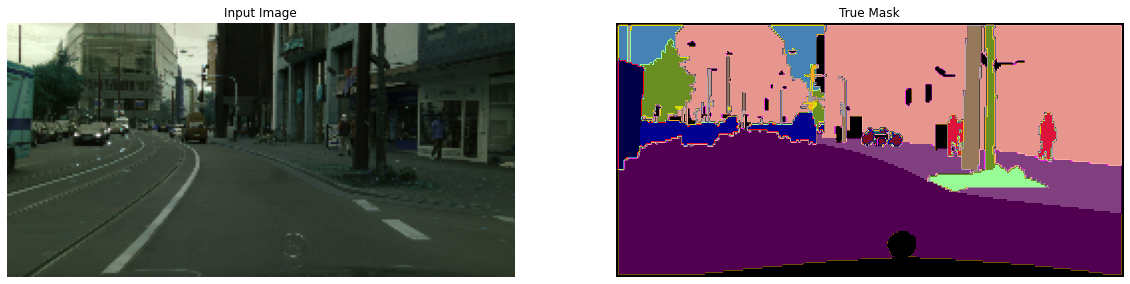

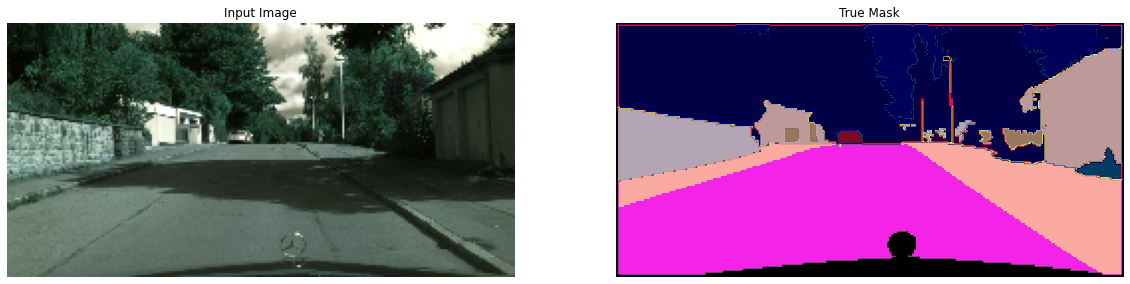

In [131]:
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## 3.Define the model
[U-Net](https://arxiv.org/abs/1505.04597)
the Encoder (downsampler) and Decoder (upsampler) are from [UNet.py](UNet.py)

### 3.1 downsampler structure
MaxPooling2D => Conv2D => Conv2D => Batchnorm(optional)

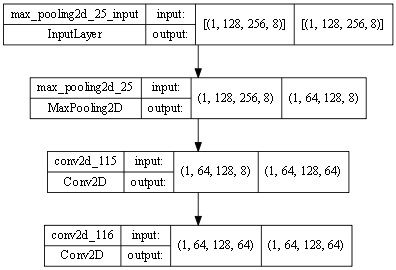

In [132]:
down_model = downsample(64, 3)

example = np.zeros((128, 256, 8))[tf.newaxis, ...]
down_result = down_model(example)

tf.keras.utils.plot_model(down_model, expand_nested=True, show_shapes=True, dpi=64)

### 3.2 upsampler structure
Conv2DTranspose => Conv2D => Conv2D => Batchnorm(optional) => Dropout(optional)

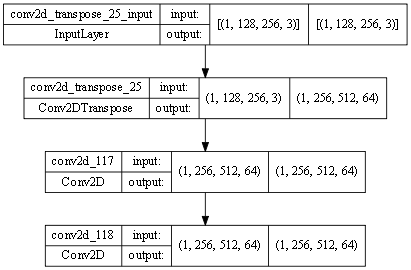

In [133]:
up_model = upsample(64, 4)

example = np.zeros((128, 256, 3))[tf.newaxis, ...]
up_result = up_model(example)

tf.keras.utils.plot_model(up_model, expand_nested=True, show_shapes=True, dpi=64)

### 3.3 build UNet model
Downsample
Upsample
Concatenate

**Optimizer: Adam**
**Loss: SparseCategoricalCrossentropy**
**metrics: MeanIoU Accuracy**

In [134]:
def unet_model():
    assert INPUT_SHAPE == (128, 256, 3)
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    down_stack = [
        downsample(64, 3, apply_pool=False),  # (batch_size, 128, 256, 64)
        downsample(128, 3),  # (batch_size, 64, 128, 128)
        downsample(256, 3),  # (batch_size, 32, 64, 128)
        downsample(512, 3),  # (batch_size, 16, 32, 256)
        downsample(1024, 3)  # (batch_size, 8, 16, 512)
    ]

    up_stack = [
        upsample(512, 3, apply_dropout=True),  # (batch_size, 16, 32, 1024)
        upsample(256, 3),  # (batch_size, 32, 64, 512)
        upsample(128, 3),  # (batch_size, 64, 128, 256)
        upsample(64, 3),  # (batch_size, 128, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2D(CLASSES, 1,
                                  strides=1,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='softmax')  # (batch_size, 128, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [135]:
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[MIoU(num_classes=CLASSES), 'accuracy'])
model._name = 'c_unet'

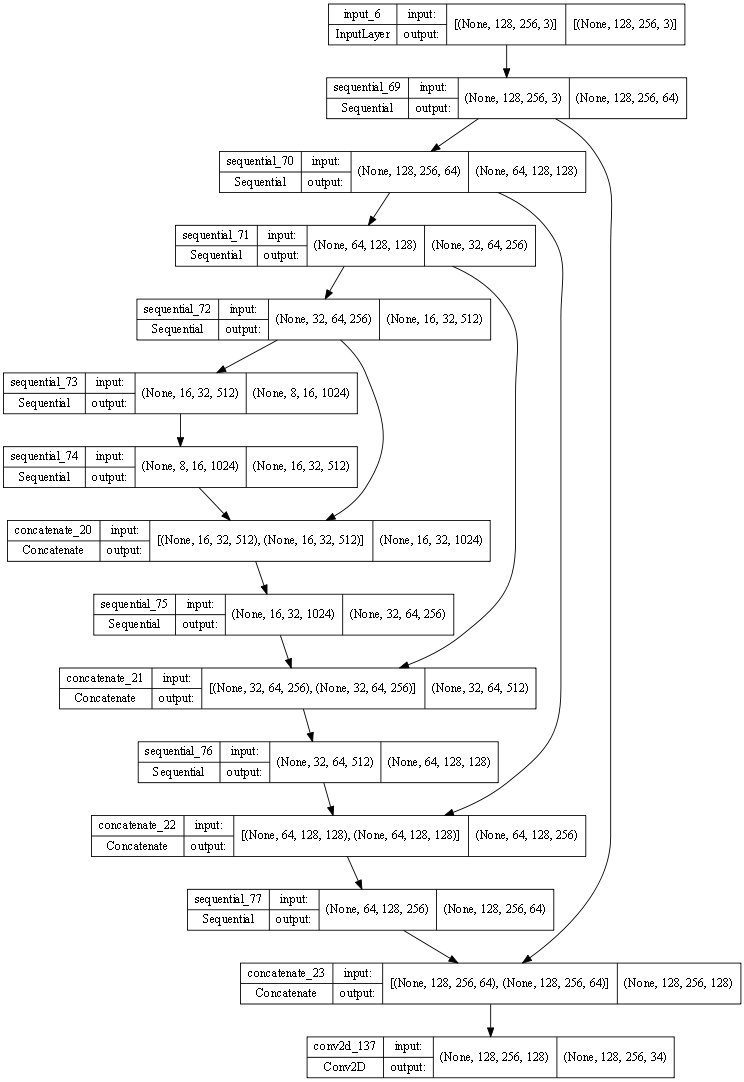

In [136]:
tf.keras.utils.plot_model(model,
                          # expand_nested=True,
                          show_shapes=True, dpi=64)

In [137]:
model.summary()

Model: "c_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_69 (Sequential)     (None, 128, 256, 64  38592       ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_70 (Sequential)     (None, 64, 128, 128  221184      ['sequential_69[0][0]']          
                                )                                                            

## 4.Train the model

### 4.1 define related functions
create_mask: argmax
show_predictions: show the model predictions
show_uncertainty: show the model uncertainty

In [138]:
def create_mask(pred_result):
    """
    transform output to mask
    :param pred_result: result from UNet
    :return pred_mask: mask
    """
    pred_result = tf.argmax(pred_result, axis=-1)
    pred_result = pred_result[..., tf.newaxis]
    return pred_result[0]

In [139]:
def show_predictions(dataset=None, random=True, num=1):
    if random:
        dataset = dataset.shuffle(BUFFER_SIZE)
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [140]:
from scipy.stats import entropy


def show_uncertainty(dataset=test_img, test_i=[1], n_sample=4, ):
    for i in range(len(test_i)):
        plt.figure(figsize=(40, 200))

        data_i = test_i[i]

        image = dataset['image'][[data_i], :, :, :] / 255.
        preds = [model(image, training=True)[0] for _ in range(n_sample)]
        pred = np.mean(preds, 0)
        aleatoric = entropy(pred, axis=-1)[..., tf.newaxis]
        epistemic = np.std(preds, axis=0).mean(-1)[..., tf.newaxis]

        display_list = [image[0], dataset['mask'][[data_i], :, :, :][0], create_mask(pred[tf.newaxis, ...]), aleatoric,
                        epistemic]
        title = ['Input Image', 'Real Mask', 'Predicted Mask', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']
        for j in range(len(display_list)):
            plt.subplot(1, len(display_list), j + 1)
            plt.title(title[j])
            if j == 1 or j == 2:
                plt.imshow(tf.keras.utils.array_to_img(display_list[j]), cmap=cmap)
            else:
                plt.imshow(tf.keras.utils.array_to_img(display_list[j]))
                plt.colorbar(fraction=0.026, pad=0.04)
            plt.axis('off')
        plt.show()

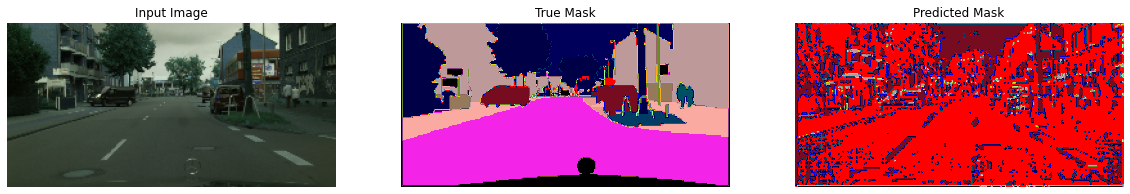

In [141]:
# initial model output
show_predictions(dataset=test_dataset)

### 4.2 TensorBoard to display train loss and metrics
%load_ext tensorboard

In [142]:
# Load the TensorBoard notebook extension
# code should be '%load_ext tensorboard' not '% load_ext tensorboard'
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 4.3 Checkpoint to save model weights

In [143]:
checkpoint_directory = "./training_checkpoints"
checkpoint_name = "ckpt"
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint,
                                     f'checkpoint_directory/U-net/',
                                     checkpoint_name=checkpoint_name,
                                     max_to_keep=3)

In [144]:
# restore from trained weights
checkpoint.restore(manager.latest_checkpoint)

### 4.4 Add Callback
**DisplayCallback**: display prediction every epoch
**SaveCheckpointsCallback**: Save Weight every epoch
**TensorBoardCallback**: Save logs every epoch

In [145]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=test_dataset, random=False)
        show_uncertainty(test_img, [1])
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


class SaveCheckpointsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        manager.save()


LOG_DIR = 'U-net'
log_dir = f"./logs/{LOG_DIR}/"
time_str = datetime.datetime.now().strftime(f"{model.name}_%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir + time_str, histogram_freq=1)

### 4.5 Train the Model
If no checkpoint_directory files will initial first or load from last epoch and add new epoches

In [ ]:
def train(model, manager, EPOCH=20):
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print(f"Restored from {manager.latest_checkpoint}")
    else:
        print("Initializing Model.")

    #load last epoch number
    initial_epoch = checkpoint.save_counter.numpy()

    model.fit(train_dataset, epochs=EPOCH + initial_epoch,
              # steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              initial_epoch=initial_epoch,
              # validation_steps=VALIDATION_STEPS,
              callbacks=[DisplayCallback(), SaveCheckpointsCallback(), tensorboard_callback])


train(model, manager, EPOCH=20)

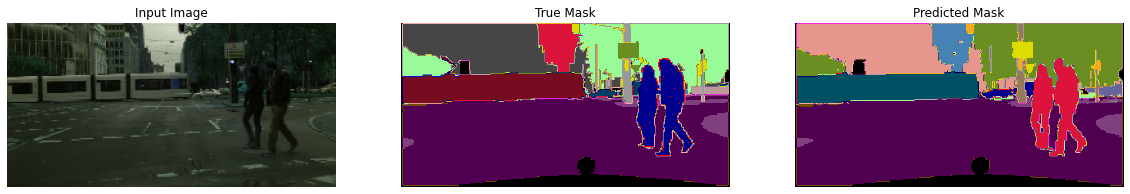

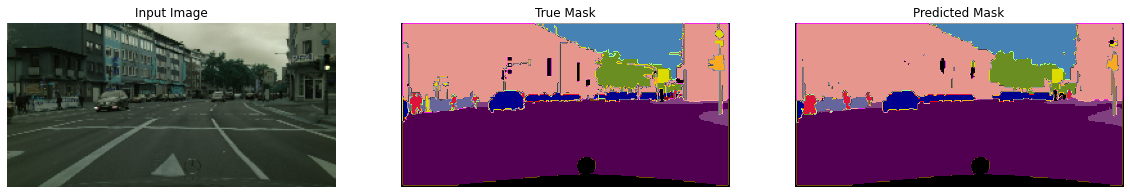

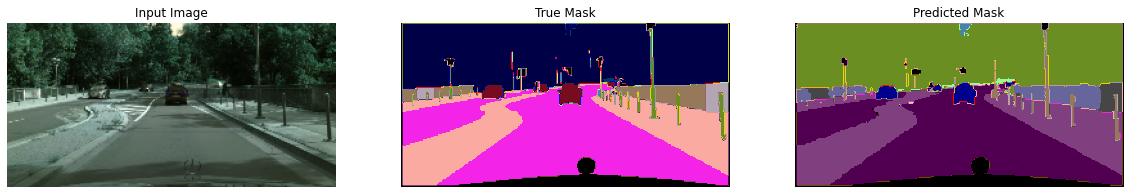

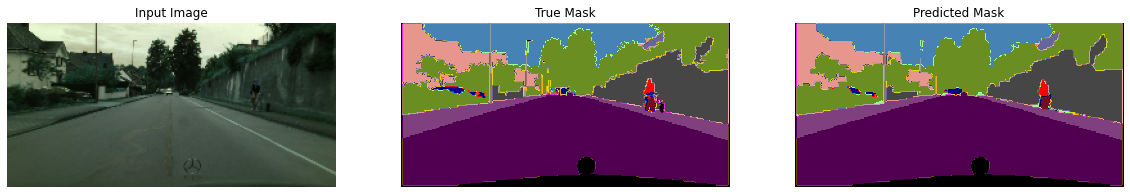

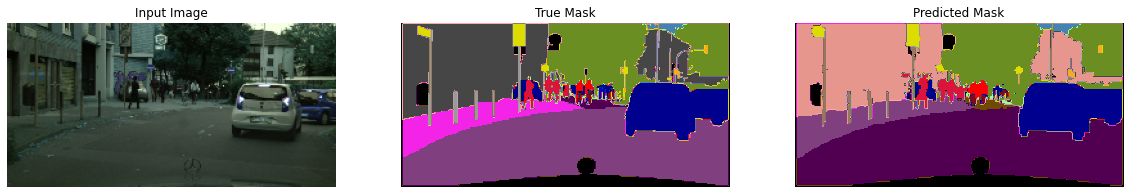

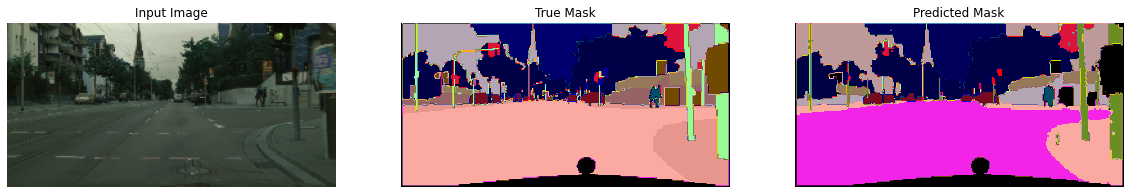

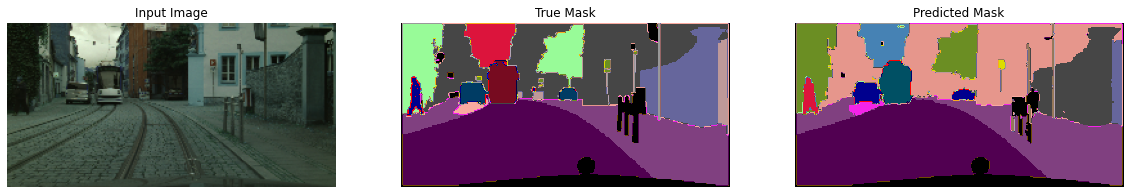

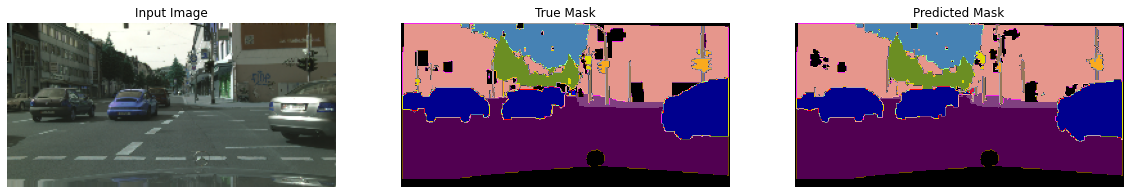

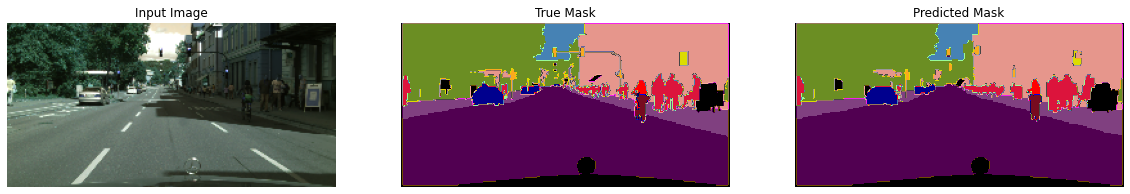

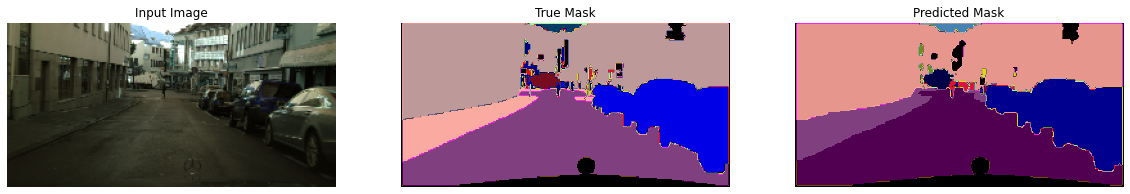

In [148]:
show_predictions(test_dataset, num=10)

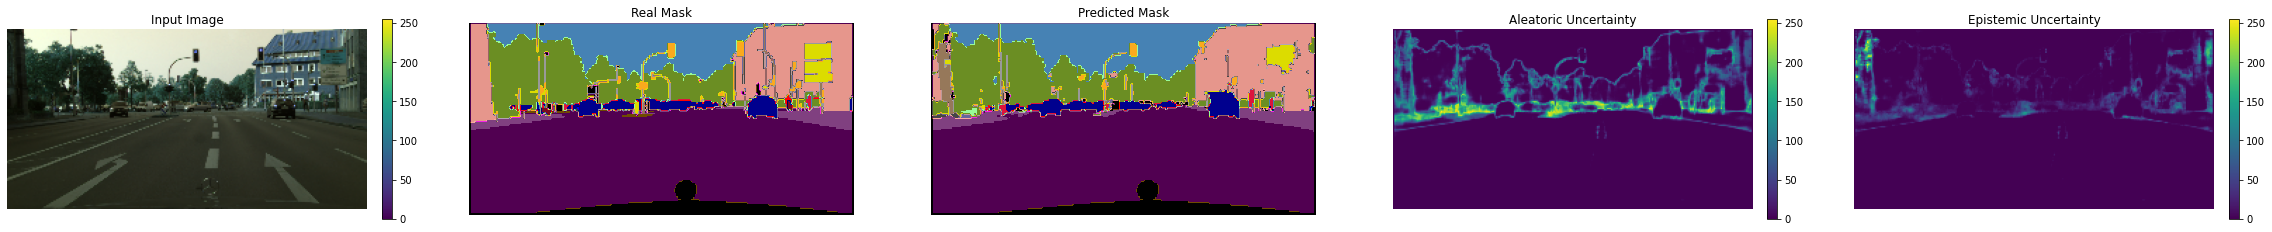

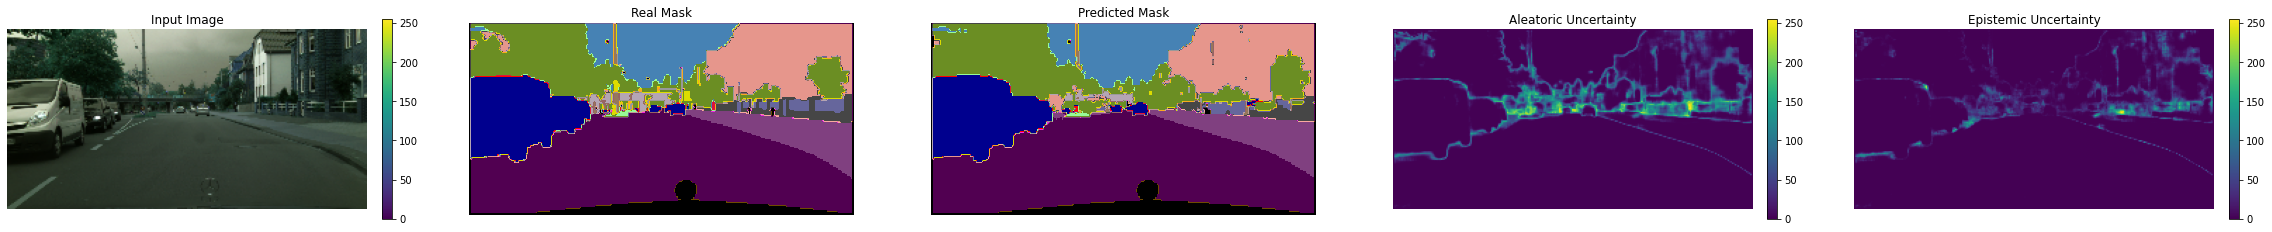

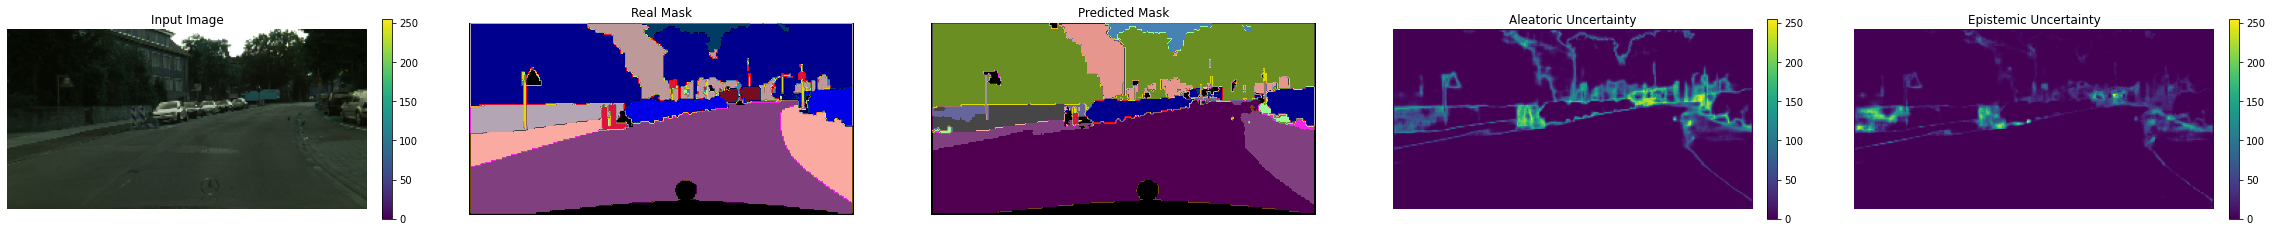

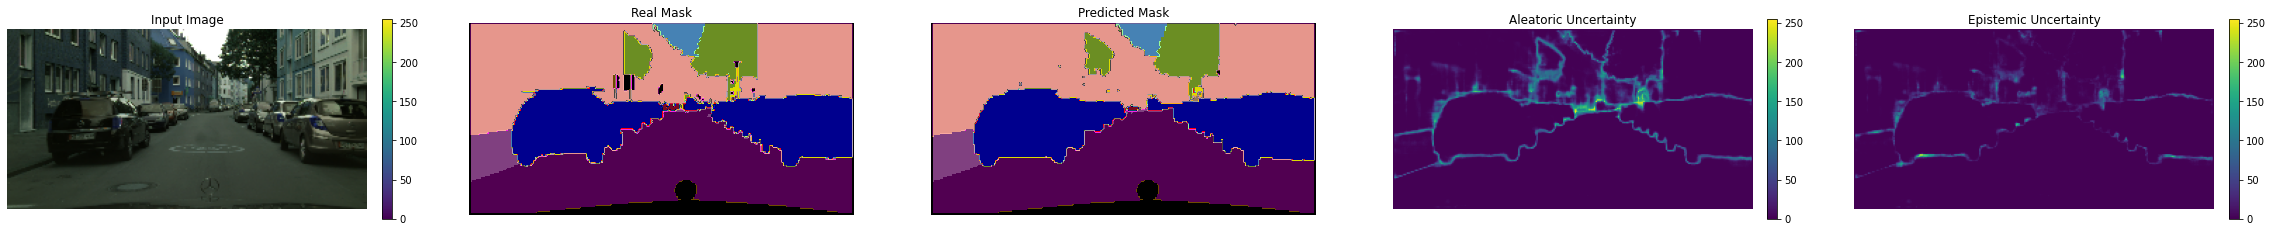

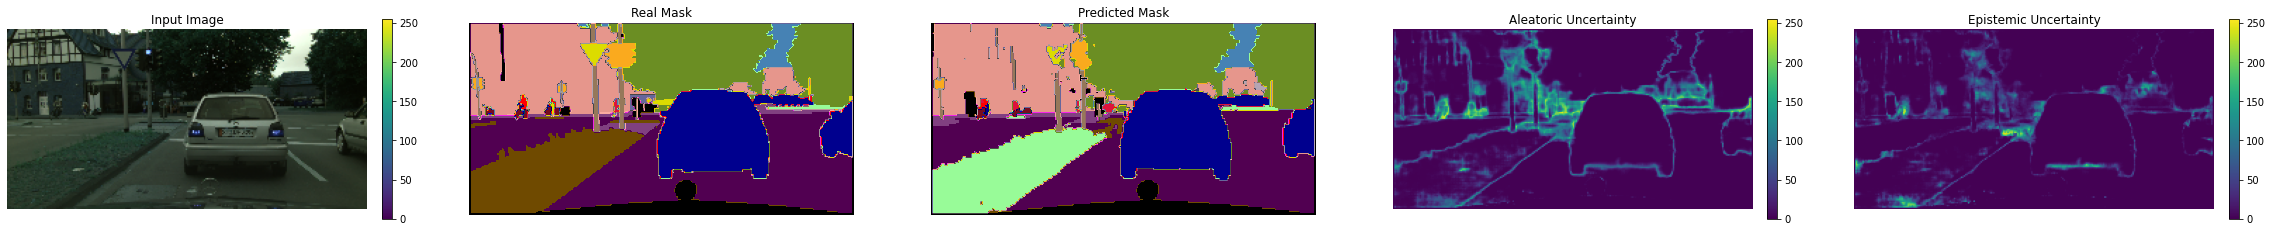

In [154]:
show_uncertainty(test_img, [495,496,497, 498, 499])

In [151]:
accuracy = []
miou = []
m_acc = tf.keras.metrics.Accuracy()
m_iou = MIoU(CLASSES)
for i in range(TEST_LENGTH):
    m_acc.update_state(test_img['mask'][i], create_mask(model.predict(test_img['image'][[i], :, :, :])))
    m_iou.update_state(test_img['mask'][i], model.predict(test_img['image'][[i], :, :, :]))
    accuracy.append(m_acc.result().numpy())
    miou.append(m_iou.result().numpy())

In [152]:
ind = np.argpartition(accuracy, -5)[-5:]
print(ind)
ind = np.argpartition(miou, -5)[-5:]
print(ind)

[7 5 8 6 9]
[495 496 497 498 499]
